### Multilayer perceptron regression

In [1]:
import pandas as pd
import numpy as np

def normalise(X):
    for i in range(X.shape[1]):
        (X[:,i]-np.min(X[:,i]))/(np.max(X[:,i])-np.min(X[:,i]))
    return X

In [2]:

### Data
df = pd.read_csv("./bin/HousingData.csv")
Y = df["MEDV"].to_numpy().reshape(-1,1)
X = df.drop(columns=["MEDV"]).to_numpy()
print(X.shape)
X[:2]

(506, 13)


array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00]])

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=4)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=345)

# Handle Missing or Inconsistent Data (if necessary)
# Use SimpleImputer to fill missing values with the mean or other strategies
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# Normalize and Standardize Data
# Use StandardScaler to standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [4]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

class MLPRegressor:
    def __init__(self, n_features, n_outFeatures, learning_rate, n_hiddenLayers, n_nodesPerLayer, activateFunc, epochs, optimizer="SGD", printOutput=True) -> None:
        self.n_features = n_features
        self.n_outFeatures = n_outFeatures
        self.learning_rate = learning_rate
        self.n_hiddenLayers = n_hiddenLayers
        self.n_nodesPerLayer = n_nodesPerLayer
        self.activateFunc = activateFunc
        self.printOutput = printOutput
        self.epochs = epochs
        self.optimizer = optimizer
        self.uniques = None

        self.layeredWeights = [np.random.rand(n_features, n_nodesPerLayer)]
        self.layeredBiases = [np.random.rand(n_nodesPerLayer)]

        for i in range(1, n_hiddenLayers):
            self.layeredWeights.append(np.random.rand(n_nodesPerLayer, n_nodesPerLayer))
            self.layeredBiases.append(np.random.rand(n_nodesPerLayer))
        
        self.layeredWeights.append(np.random.rand(n_nodesPerLayer, n_outFeatures))
        self.layeredBiases.append(np.random.rand(n_outFeatures))
    
    def printMetrics(self, preds, true):
        mae = mean_absolute_error(true, preds)
        mse = mean_squared_error(true, preds)
        rmse = mean_squared_error(true, preds, squared=False)
        r2 = r2_score(true, preds)

        print(f"MAE = {mae:.2f}", end="\t")
        print(f"MSE = {mse:.2f}", end="\t")
        print(f"RMSE = {rmse:.2f}", end="\t")
        print(f"R-squared (R²) = {r2:.2f}")

    def MSE(self, y_pred, y_true):
        dif = y_pred-y_true
        sq = np.square(dif)
        MSE = np.sum(sq)/len(y_true)
        return MSE
    
    def oneHotLabels(self, Y):
        out = []
        categories = self.uniques
        for i in Y:
            num_categories = len(categories)
            encoding = np.eye(num_categories)
            index = np.where(categories==i)
            out.append(encoding[index].squeeze())
        return np.array(out)

    def activationFunc(self,X):
        if self.activateFunc == "ReLU":
            return np.maximum(0, X)
        elif self.activateFunc == "tanh":
            return np.tanh(X)
        elif self.activateFunc == "sigmoid":
            return 1 / (1 + np.exp(-X))

    def derivActivation(self,X):
        if self.activateFunc == "ReLU":
            return np.maximum(0, X)
        elif self.activateFunc == "tanh":
            return 1 - np.tanh(X) ** 2
        elif self.activateFunc == "sigmoid":
            return (1 / (1 + np.exp(-X))) * (1 - (1 / (1 + np.exp(-X))))

    def backward(self, x, y, outputs, activations):
        m = x.shape[0]
        dZs = [activations[-1] - y]
        dWs = [(1/m) * activations[-2].T @ dZs[-1]]
        dBs = [(1/m) * np.sum(dZs[-1], axis = 0)]

        for i in range(self.n_hiddenLayers):
            dZs.append(dZs[-1] @ self.layeredWeights[-1-i].T * self.derivActivation(outputs[-2-i]))
            dWs.append((1/m) * activations[-3-i].T @ dZs[-1])
            dBs.append((1/m) * np.sum(dZs[-1], axis=0))
        dWs.reverse()
        dBs.reverse()
        return dWs, dBs

    def forward(self,X):
        curMat = X
        out = []
        activ = [X]
        for i in range(self.n_hiddenLayers):
            curMat = curMat @ self.layeredWeights[i] + self.layeredBiases[i]
            out.append(curMat)
            curMat = self.activationFunc(curMat)
            activ.append(curMat)
        
        curMat = curMat @ self.layeredWeights[-1] + self.layeredBiases[-1]
        out.append(curMat)
        # curMat = self.softmax(curMat)  because no activation required in last layer
        activ.append(curMat)
        
        return out, activ
    
    def update(self, dWs,dBs):
        for i in range(self.n_hiddenLayers + 1):
            self.layeredWeights[i] -= (self.learning_rate * dWs[i])
            self.layeredBiases[i] -= (self.learning_rate * dBs[i])
        return None
    
    def predict(self, X):
        outputs, activations = self.forward(X)
        return activations[-1]
    
    def evaluate_wandb(self,X,Y):
        preds = self.predict(X)

        mae = mean_absolute_error(Y, preds)
        mse = mean_squared_error(Y, preds)
        rmse = mean_squared_error(Y, preds, squared=False)
        r2 = r2_score(Y, preds)

        return mae, mse, rmse, r2

    def train(self, X_train, Y_train, X_val, Y_val):
        self.uniques = np.unique(Y_train)
        N = len(X_train)
        for epoch in range(self.epochs):
            if (epoch%100 == 0 and self.printOutput==True):
                preds = self.predict(X_val)
                print(f"Epoch = {epoch}")
                self.printMetrics(preds,Y_val)
                
            if (self.optimizer == "SGD"):
                for i in range(N):
                    out, activations = self.forward(X_train[i].reshape(1,self.n_features))
                    dWs, dBs = self.backward(X_train[i], Y_train[i].reshape(1,self.n_outFeatures), out, activations)
                    self.update(dWs,dBs)
            elif (self.optimizer == "BatchGD"):
                out, activations = self.forward(X_train)
                dWs, dBs = self.backward(X_train, Y_train, out, activations)
                self.update(dWs,dBs)
            elif (self.optimizer == "MiniBatchGD"):
                batchSize = int(N/10)
                for i in range(0, N, batchSize):
                    out, activations = self.forward(X_train[i:min(batchSize+i, N)])
                    dWs, dBs = self.backward(X_train[i:min(batchSize+i, N)], Y_train[i:min(batchSize+i, N)], out, activations)
                    self.update(dWs,dBs)

        

In [5]:
n_features=X_train.shape[1]
n_outFeatures = 1
lr = 0.01

model = MLPRegressor(n_features, n_outFeatures, lr, n_hiddenLayers=1,n_nodesPerLayer=14,activateFunc="ReLU", optimizer="SGD",epochs=1000)
model.train(X_train,Y_train,X_val,Y_val)

Epoch = 0
MAE = 20.86	MSE = 560.35	RMSE = 23.67	R-squared (R²) = -3.49
Epoch = 100
MAE = 3.37	MSE = 21.13	RMSE = 4.60	R-squared (R²) = 0.83
Epoch = 200
MAE = 2.48	MSE = 13.62	RMSE = 3.69	R-squared (R²) = 0.89
Epoch = 300
MAE = 2.65	MSE = 14.67	RMSE = 3.83	R-squared (R²) = 0.88
Epoch = 400
MAE = 2.54	MSE = 13.79	RMSE = 3.71	R-squared (R²) = 0.89
Epoch = 500
MAE = 2.69	MSE = 12.83	RMSE = 3.58	R-squared (R²) = 0.90
Epoch = 600
MAE = 2.63	MSE = 12.27	RMSE = 3.50	R-squared (R²) = 0.90
Epoch = 700
MAE = 2.84	MSE = 13.65	RMSE = 3.69	R-squared (R²) = 0.89
Epoch = 800
MAE = 3.05	MSE = 18.31	RMSE = 4.28	R-squared (R²) = 0.85
Epoch = 900
MAE = 3.29	MSE = 21.13	RMSE = 4.60	R-squared (R²) = 0.83


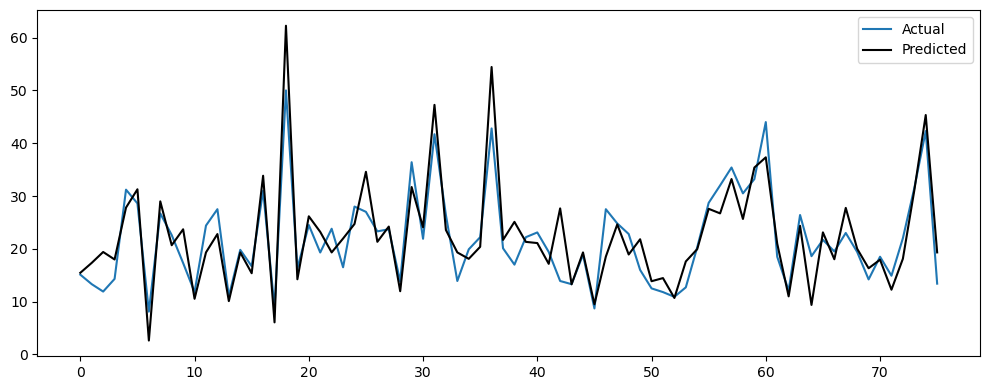

MAE = 3.42	MSE = 20.01	RMSE = 4.47	R-squared (R²) = 0.75


In [6]:
### Plotting the results on y_test
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(Y_test,label="Actual")

Y_pred = model.predict(X_test)
plt.plot(Y_pred,c="black",label="Predicted")

plt.tight_layout()
plt.legend()
plt.show()

model.printMetrics(Y_pred,Y_test)

### 3.3: Model Training & Hyperparameter Tuning using W&B

In [7]:
import wandb
import numpy as np

# Initialize W&B
wandb.init(project="SMAI_A3_q3-MultiLayerPerceptronRegressor", entity="its_mrpsycho")

myDict = {
    "ReLU":1,
    "tanh":2,
    "sigmoid":3,
    "SGD":4,
    "BatchGD":5,
    "MiniBatchGD":6
}

data = [
    ["ReLU", 1],
    ["tanh", 2],
    ["sigmoid", 3],
    ["SGD", 4],
    ["BatchGD", 5],
    ["MiniBatchGD", 6]
]

# Define a function to log to W&B
def log_to_wandb(mae, mse, rmse, r2, hLayers, nodesPerLayer, optimizer, activFunc, learning_rate, epochs):
    wandb.log({
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "Hidden Layers": hLayers,
        "nodesPerLayer": nodesPerLayer,
        "Optimization method": optimizer,
        "Activation Function": activFunc,
        "learning_rate": learning_rate,
        "epochs": epochs
    })

# Hyperparameter Search
learning_rates = [0.01, 0.001]
epochs = [1000]
hiddenLayers = [1,2,3]
nodesPerLayer = [3,4,5]
activationFuncs = ["ReLU","tanh","sigmoid"]
optimizers = ["SGD","BatchGD","MiniBatchGD"]


columns = ["Category", "Value"]
table = wandb.Table(data=data, columns=columns)
wandb.log({"custom_table": table})

for lr in learning_rates:
    for num_epochs in epochs:
        for nLayers in hiddenLayers:
            for nNodes in nodesPerLayer:
                for activFunc in activationFuncs:
                    for optimizer in optimizers:
                        if activFunc == "ReLU" and optimizer == "SGD":
                            continue
                        # Create and train your model with the current hyperparameters
                        model = MLPRegressor(n_features, n_outFeatures, lr, n_hiddenLayers=nLayers, n_nodesPerLayer=nNodes, activateFunc=activFunc, optimizer=optimizer,epochs=num_epochs, printOutput=False)
                        model.train(X_train, Y_train, X_val, Y_val)

                        # Evaluate on the validation set
                        mae, mse, rmse, r2 = model.evaluate_wandb(X_val, Y_val)

                        # Log the results to W&B
                        log_to_wandb(mae, mse, rmse, r2, nLayers, nNodes, myDict[optimizer], myDict[activFunc], float(lr), num_epochs)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: its_mrpsycho. Use `wandb login --relogin` to force relogin


Evalutaing the best model

Epoch = 0
MAE = 23.41	MSE = 677.31	RMSE = 26.03	R-squared (R²) = -4.43
Epoch = 100
MAE = 5.17	MSE = 63.78	RMSE = 7.99	R-squared (R²) = 0.49
Epoch = 200
MAE = 4.51	MSE = 47.70	RMSE = 6.91	R-squared (R²) = 0.62
Epoch = 300
MAE = 4.14	MSE = 38.25	RMSE = 6.18	R-squared (R²) = 0.69
Epoch = 400
MAE = 3.89	MSE = 32.93	RMSE = 5.74	R-squared (R²) = 0.74
Epoch = 500
MAE = 3.68	MSE = 29.77	RMSE = 5.46	R-squared (R²) = 0.76
Epoch = 600
MAE = 3.49	MSE = 27.50	RMSE = 5.24	R-squared (R²) = 0.78
Epoch = 700
MAE = 3.33	MSE = 25.59	RMSE = 5.06	R-squared (R²) = 0.79
Epoch = 800
MAE = 3.22	MSE = 24.17	RMSE = 4.92	R-squared (R²) = 0.81
Epoch = 900
MAE = 3.13	MSE = 23.18	RMSE = 4.81	R-squared (R²) = 0.81


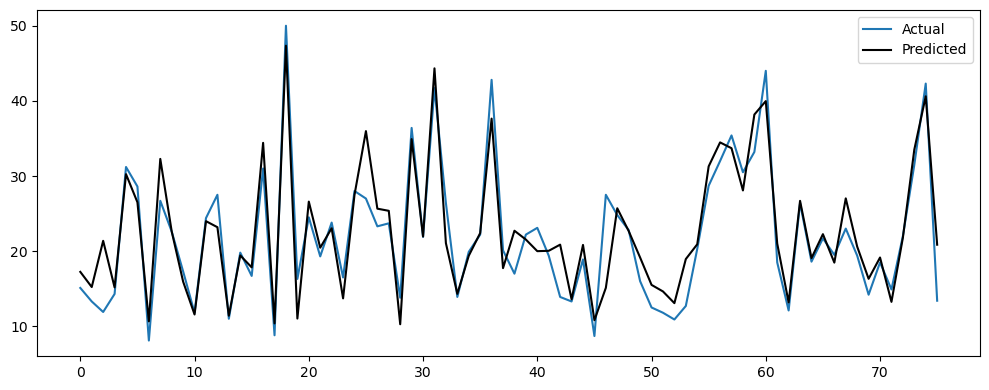

MAE = 2.46	MSE = 11.63	RMSE = 3.41	R-squared (R²) = 0.85


In [9]:
import numpy as np
from sklearn.metrics import classification_report

modelOptimal = model = MLPRegressor(n_features, n_outFeatures, lr, n_hiddenLayers=1,n_nodesPerLayer=6,activateFunc="sigmoid", optimizer="SGD",epochs=1000)
modelOptimal.train(X_train, Y_train, X_val, Y_val)

plt.figure(figsize=(10,4))
plt.plot(Y_test,label="Actual")

Y_pred = model.predict(X_test)
plt.plot(Y_pred,c="black",label="Predicted")

plt.tight_layout()
plt.legend()
plt.show()

model.printMetrics(Y_pred,Y_test)